# Analyse des tendances

On se propose dans cet exercice d'extraire la tendance instantannée de déforestation d'un site. Pour cela on va exploiter dans un premier temps les données optiques pour identifier les éléments majeurs comme la saisonnalité que l'on réexploitera sur les données radar.

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import STL
from scipy.interpolate import interp1d

import esg_deforestation_radar as sentinel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

In [2]:
# Mise à jour automatique des codes annexes.
%reload_ext autoreload
%autoreload 2

In [3]:
# Choix d'une zone à étudier.
target = "../data/Barro-Alto"
zone = sentinel.getzone(target)
zone

{'name': 'Barro Alto - Nickel (Brasil)',
 'bbox': [-15.12, -49.06, -15.02, -48.92],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD/Barro-Alto',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Barro-Alto',
 'LAI': '/Volumes/JLTD/Sentinel/LAI',
 'TCI': '/Volumes/JLTD/Sentinel/TCI'}

## Traitement des données optiques
On va extraire la saisonnalité principale que l'on va modéliser.

In [4]:
# Récupération des données optiques.
F = sentinel.dataset.gls(zone,'FCOVER')
F

,FILE,REVISION,FCOVER,RMSE,PR
DATE,,,,,
2016-01-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.808591,0.124193,0.821652
2016-01-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.799199,0.032586,1.000000
2016-01-31,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.806481,0.033995,1.000000
2016-02-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.811652,0.034934,0.998123
2016-02-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.812406,0.036070,0.999374
...,...,...,...,...,...
2021-04-20,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.697274,0.098816,0.996245
2021-04-30,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.671417,0.099825,0.995620
2021-05-10,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.630641,0.103970,0.990613


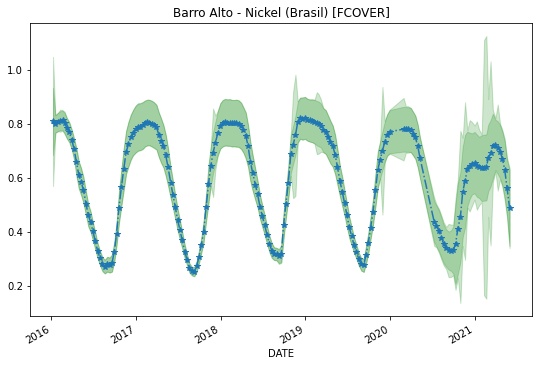

In [5]:
sentinel.dataset.glsplot(zone,'FCOVER')

### Interpolation
Il faur rendre les données régulièrement échantillonnées. Le plus propre est de passer par une interpolation linéaire en conservant la fréquence de 10 jours moyenne.

In [6]:
# Interpolation à 10 jours.
t = pd.date_range(F.index[0],periods=(F.index[-1]-F.index[0]).days/10+1, freq='10D')
Fc = interp1d(pd.to_numeric(F.index),F['FCOVER'].values,fill_value="extrapolate")
z = Fc(pd.to_numeric(t))
Y = pd.Series(data=z,index=t,name='FCOVER')
Y

2016-01-10    0.808591
2016-01-20    0.799199
2016-01-30    0.805819
2016-02-09    0.811135
2016-02-19    0.812330
                ...   
2021-04-13    0.707549
2021-04-23    0.689517
2021-05-03    0.659184
2021-05-13    0.610427
2021-05-23    0.542842
Freq: 10D, Name: FCOVER, Length: 197, dtype: float64

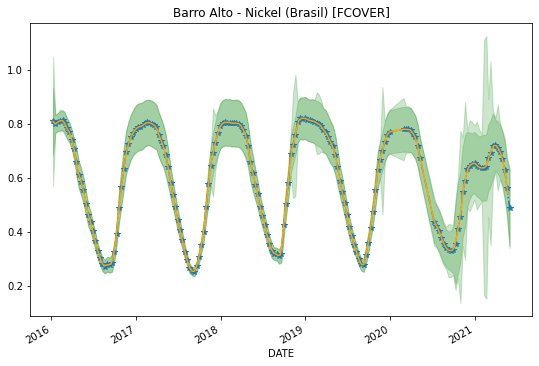

In [7]:
sentinel.dataset.glsplot(zone,'FCOVER')
Y.plot(color='orange') ;

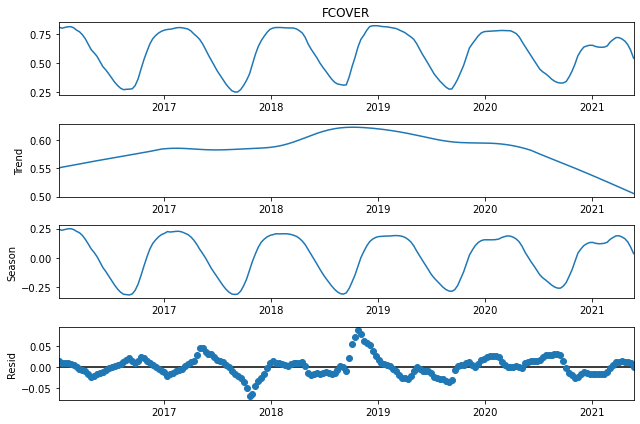

In [11]:
res = STL(Y,period=37).fit()
res.plot();

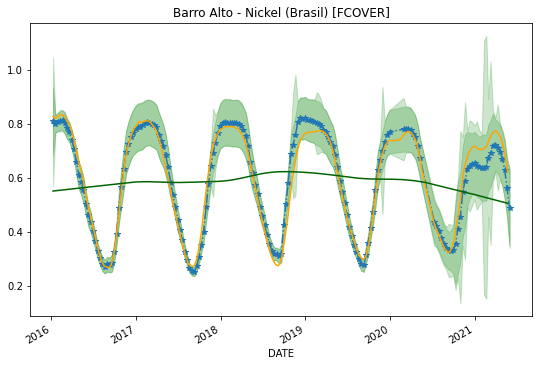

In [12]:
sentinel.dataset.glsplot(zone,'FCOVER')

season = res.trend.mean()+res.seasonal
season.plot(color='orange')
res.trend.plot(color='darkgreen') ;

In [13]:
from statsmodels.tsa.deterministic import DeterministicProcess as DP

In [18]:
res = DP(t, constant=True, order=0, period=365.25/10.0, fourier=3)
X = res.in_sample()

<AxesSubplot:>

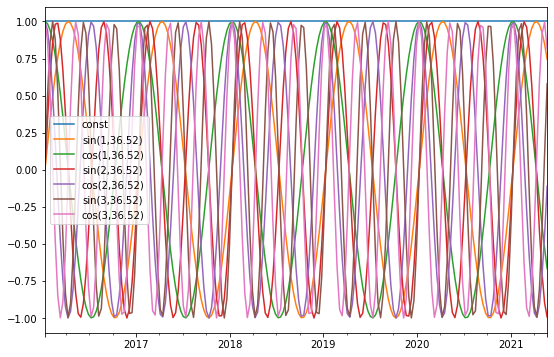

In [19]:
res.in_sample().plot()

In [20]:
res = sm.OLS(Z['FCOVER'],X).fit()

In [21]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 FCOVER   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     474.0
Date:                Tue, 15 Jun 2021   Prob (F-statistic):          2.00e-111
Time:                        09:58:18   Log-Likelihood:                 328.78
No. Observations:                 197   AIC:                            -643.6
Df Residuals:                     190   BIC:                            -620.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5845      0.003    176.087   

In [22]:
z = res.predict()

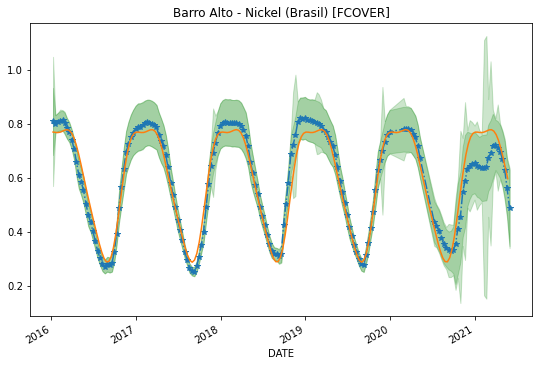

In [23]:
sentinel.dataset.glsplot(zone,'FCOVER')
plt.plot(t,z)

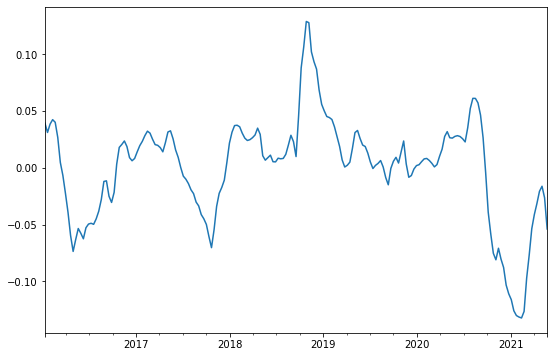

In [24]:
r = Z['FCOVER']-z
r.plot() ;

<BarContainer object of 41 artists>

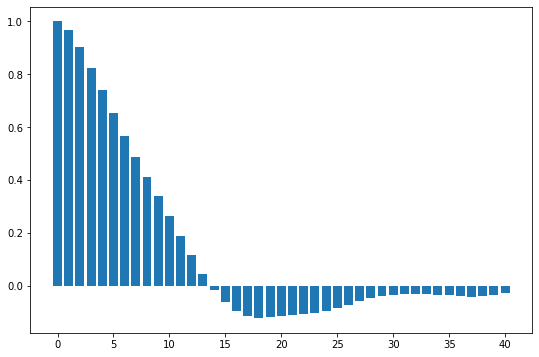

In [27]:
a = tsa.acf(r,fft=True,nlags=40)
plt.bar(range(len(a)),a)

## Données de température

In [29]:
TCI = sentinel.dataset.gls(zone,'TCI')
TCI

,FILE,REVISION,TCI,RMSE,PR
DATE,,,,,
2017-01-01,/Volumes/JLTD/Sentinel/TCI/C0102496/LST10_TCI_...,9,NaN,NaN,0.000000
2017-01-11,/Volumes/JLTD/Sentinel/TCI/C0102496/LST10_TCI_...,9,0.769299,0.470627,0.055345
2017-01-21,/Volumes/JLTD/Sentinel/TCI/C0102496/LST10_TCI_...,9,0.684505,0.433478,0.121911
2017-02-01,/Volumes/JLTD/Sentinel/TCI/C0102496/LST10_TCI_...,9,0.726749,0.425780,0.044623
2017-02-11,/Volumes/JLTD/Sentinel/TCI/C0102496/LST10_TCI_...,9,0.772955,0.412044,0.060348
...,...,...,...,...,...
2021-04-11,/Volumes/JLTD/Sentinel/TCI/C0102494/LST10_TCI_...,9,0.482677,0.000000,0.909160
2021-04-21,/Volumes/JLTD/Sentinel/TCI/C0102494/LST10_TCI_...,9,0.646216,0.000000,0.985870
2021-05-01,/Volumes/JLTD/Sentinel/TCI/C0102494/LST10_TCI_...,9,0.599504,0.000000,0.992088
